<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Graphs in Machine Learning</h1>
<h1>RGNs, K-Nearest Neighbours and DBSCAN</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt 

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider

import tqdm as tq
from tqdm import tqdm

import networkx as nx
import scipy
from scipy.spatial import distance_matrix

import sklearn
from sklearn import datasets
from sklearn.cluster import DBSCAN

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: c934b8c2fde3f2a83d69e820cd8070b0aa766ff1

ipywidgets: 7.5.1
scipy     : 1.5.2
sklearn   : 0.23.2
pandas    : 1.1.3
watermark : 2.1.0
numpy     : 1.19.2
tqdm      : 4.50.2
networkx  : 2.5
matplotlib: 3.3.2
json      : 2.0.9



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Random Geometric Graphs

In [4]:
N=100

In [5]:
coords = np.random.random((N, 2))

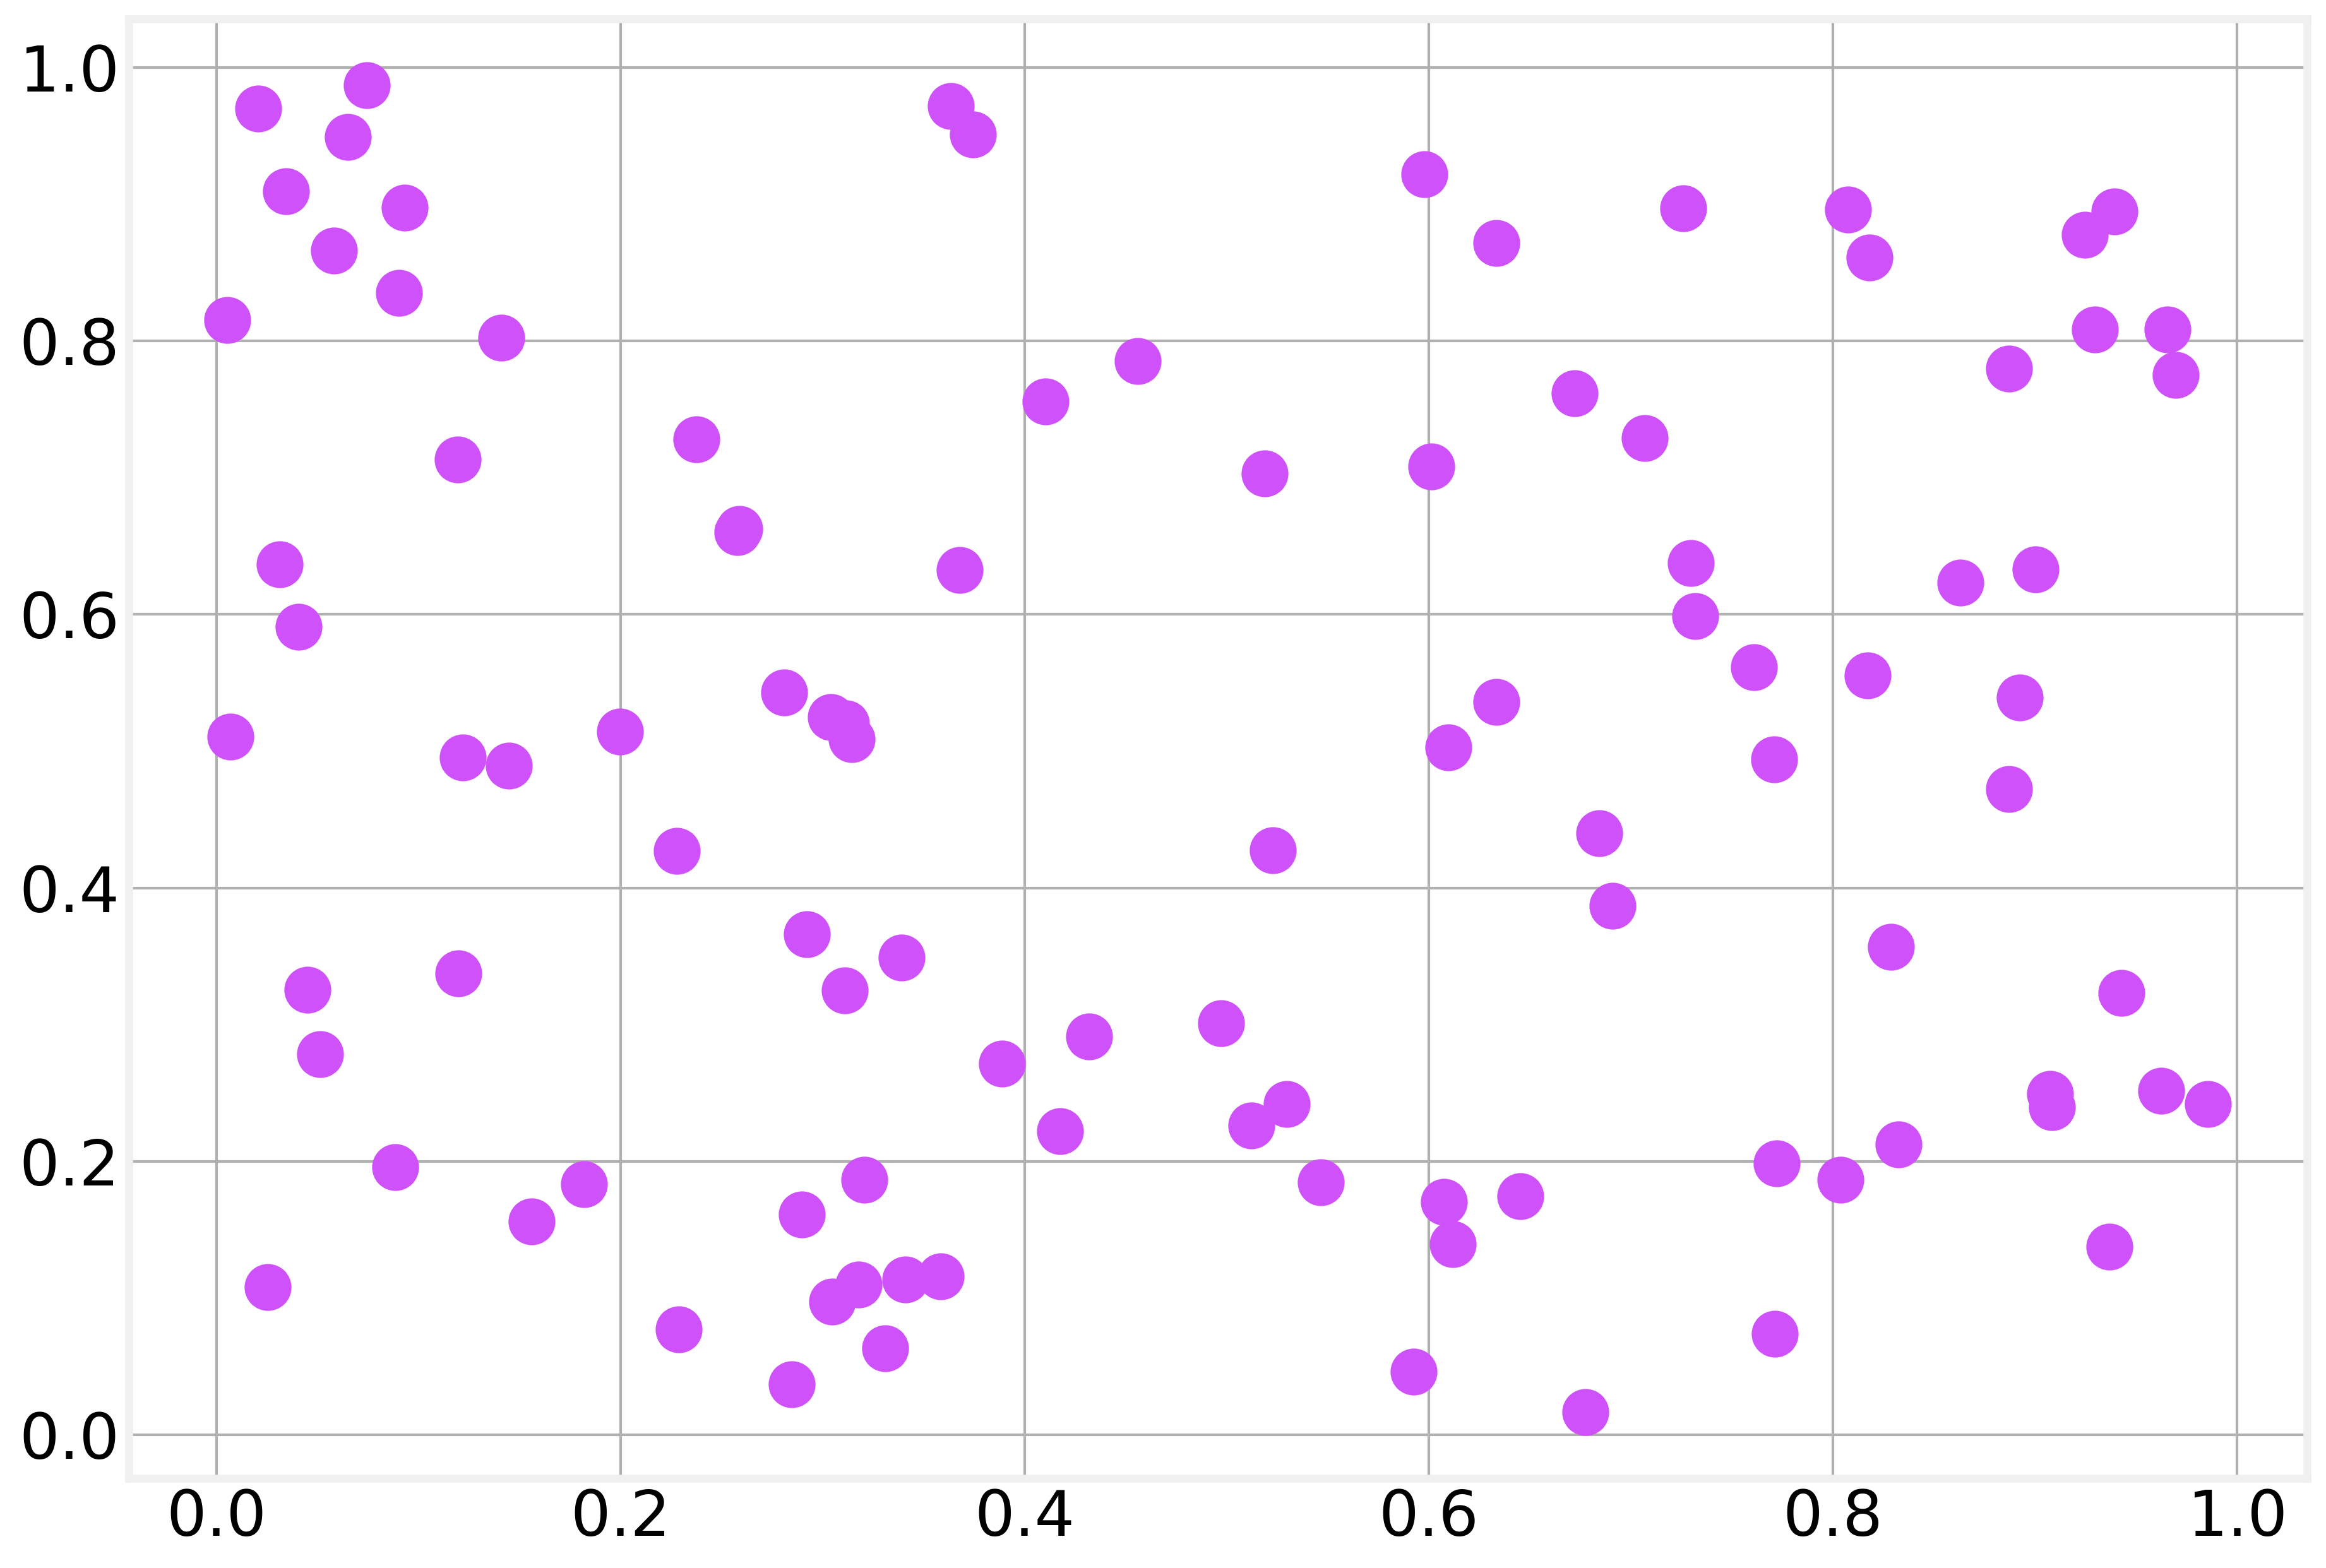

In [6]:
plt.scatter(x=coords[:, 0], y=coords[:, 1], color=colors[1], s=300)

In [7]:
matrix = distance_matrix(coords, coords, 2)

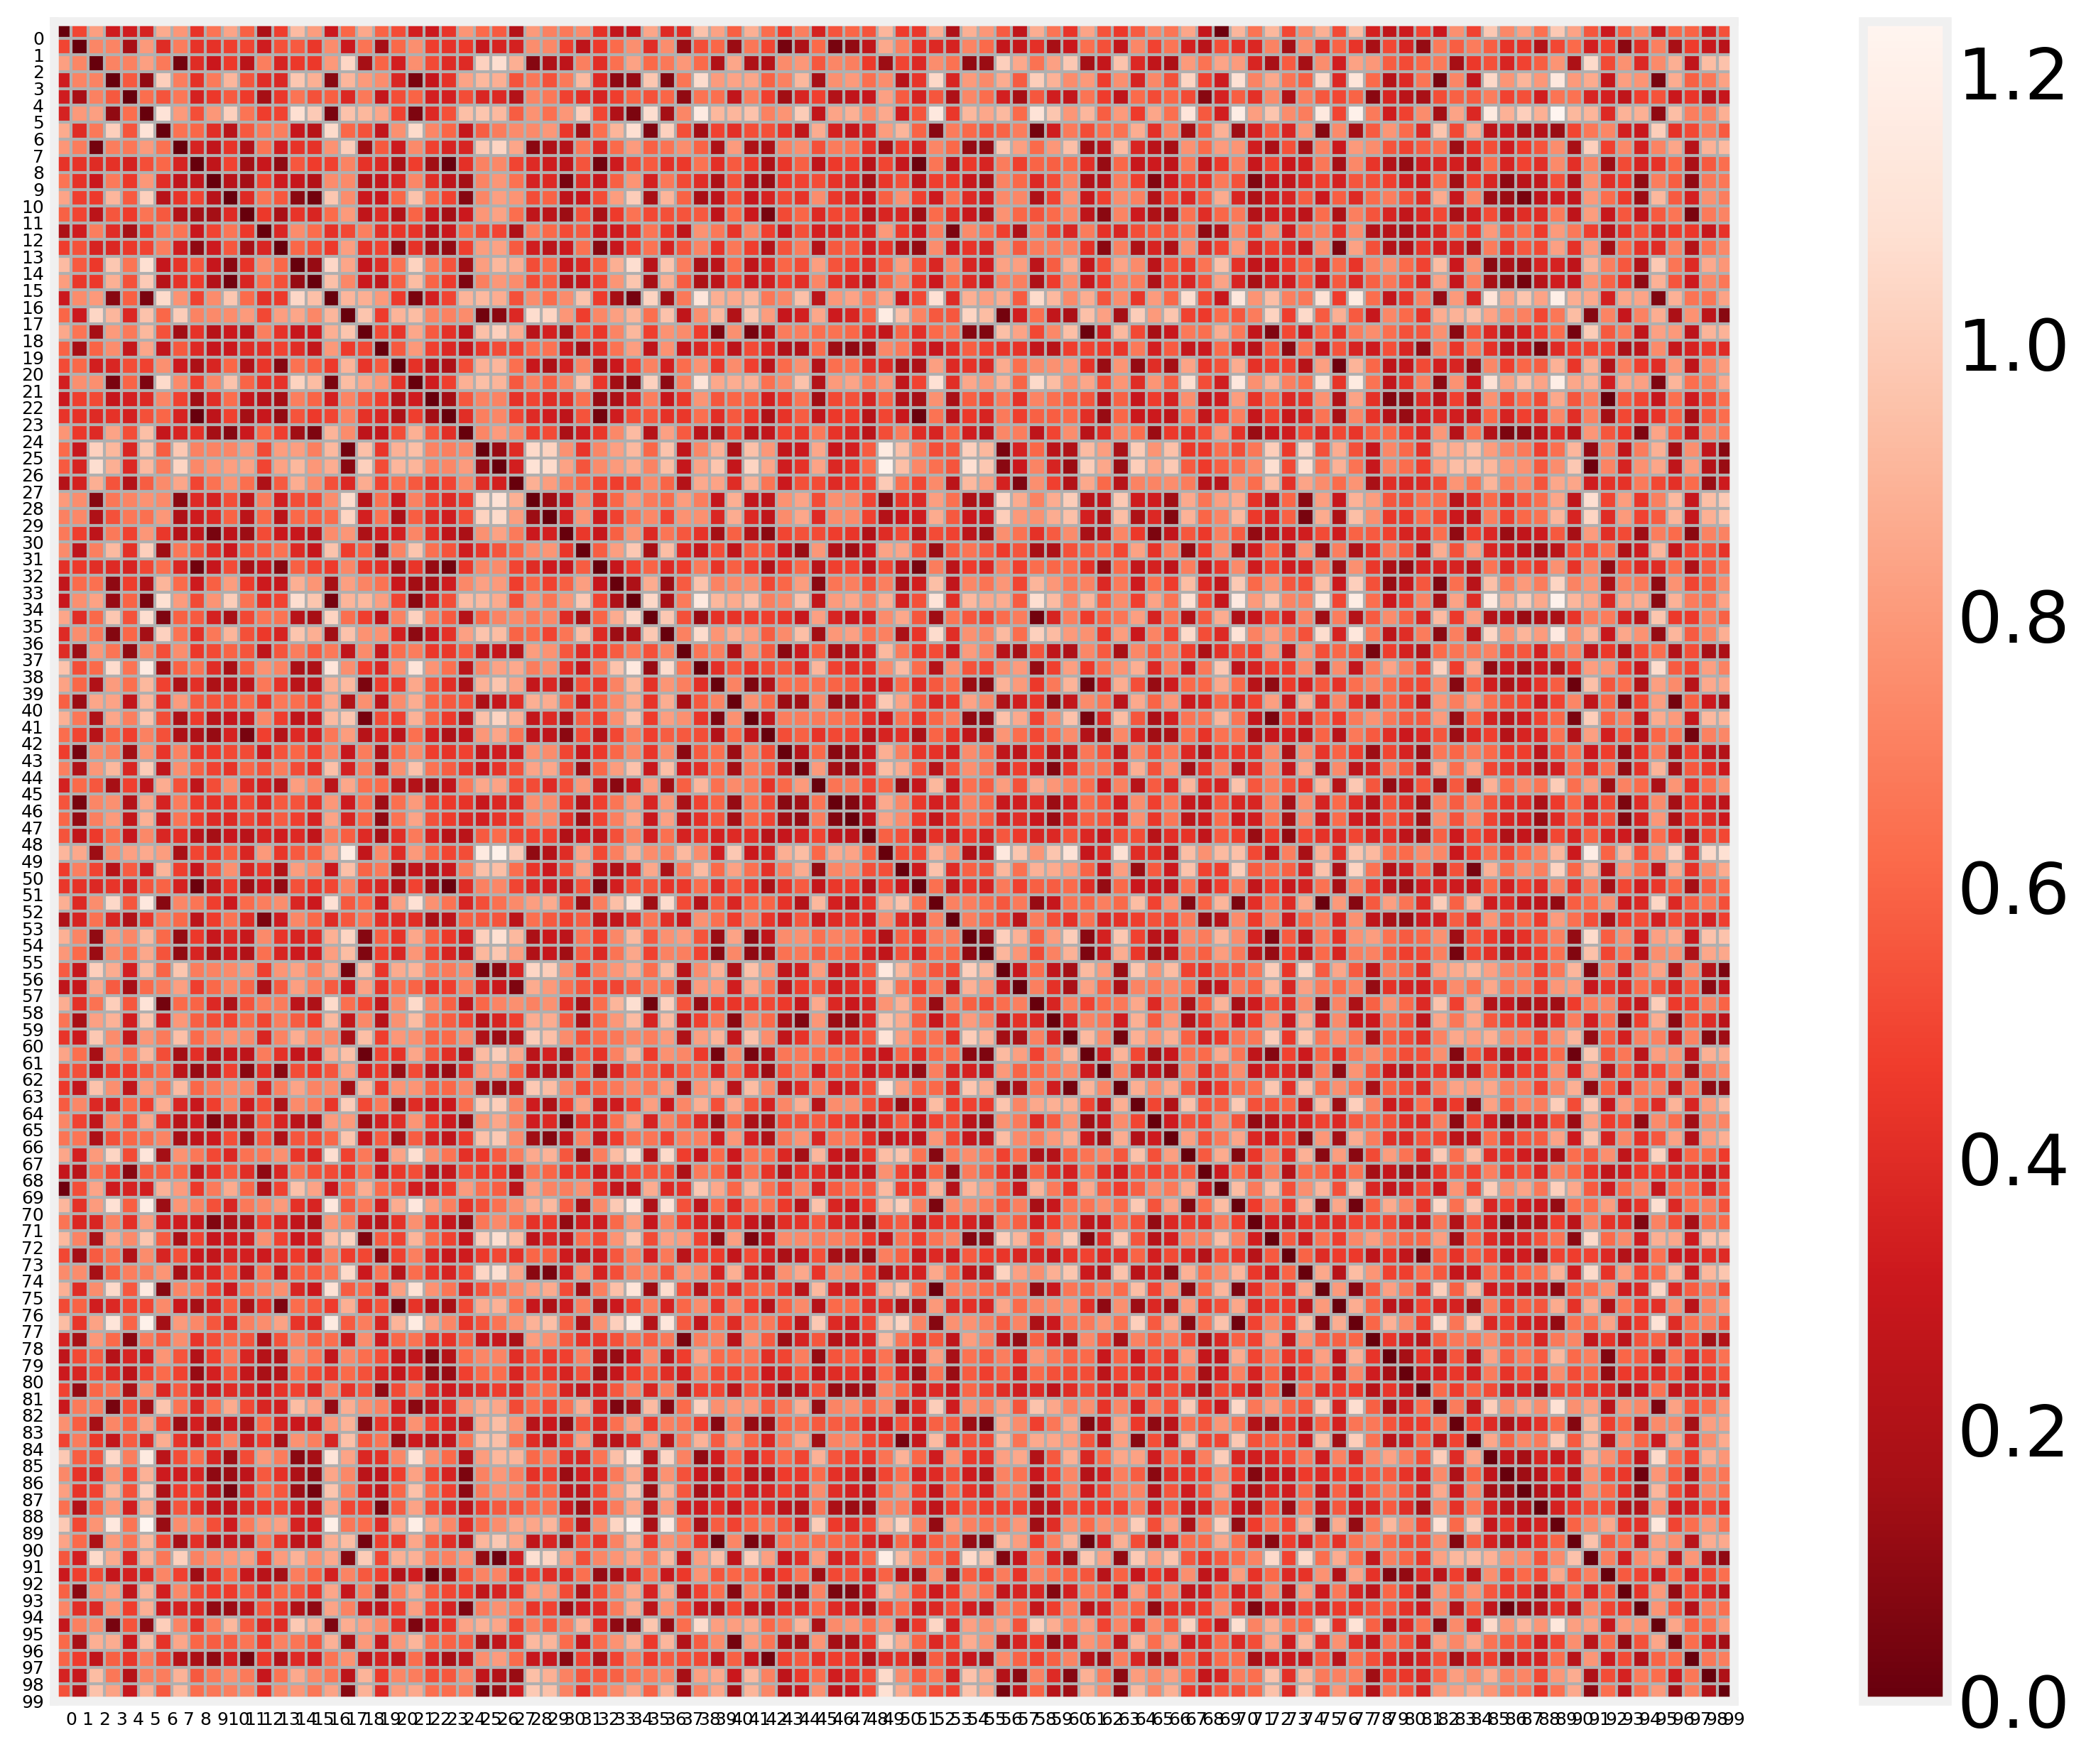

In [8]:
plt.imshow(matrix, cmap=plt.cm.Reds_r)
plt.yticks(np.arange(0.5, N, 1), np.arange(N), fontsize=6)
plt.xticks(np.arange(0.5, N, 1), np.arange(N), fontsize=6)
plt.colorbar();

In [9]:
hist = pd.DataFrame(list(Counter(np.round(matrix[matrix>0].flatten()*100)/100).items()), columns=['d', 'P(d)'])

In [10]:
hist.sort_values('d', inplace=True)
hist['P(d)']/=hist['P(d)'].sum()

Text(0, 0.5, 'C(d)')

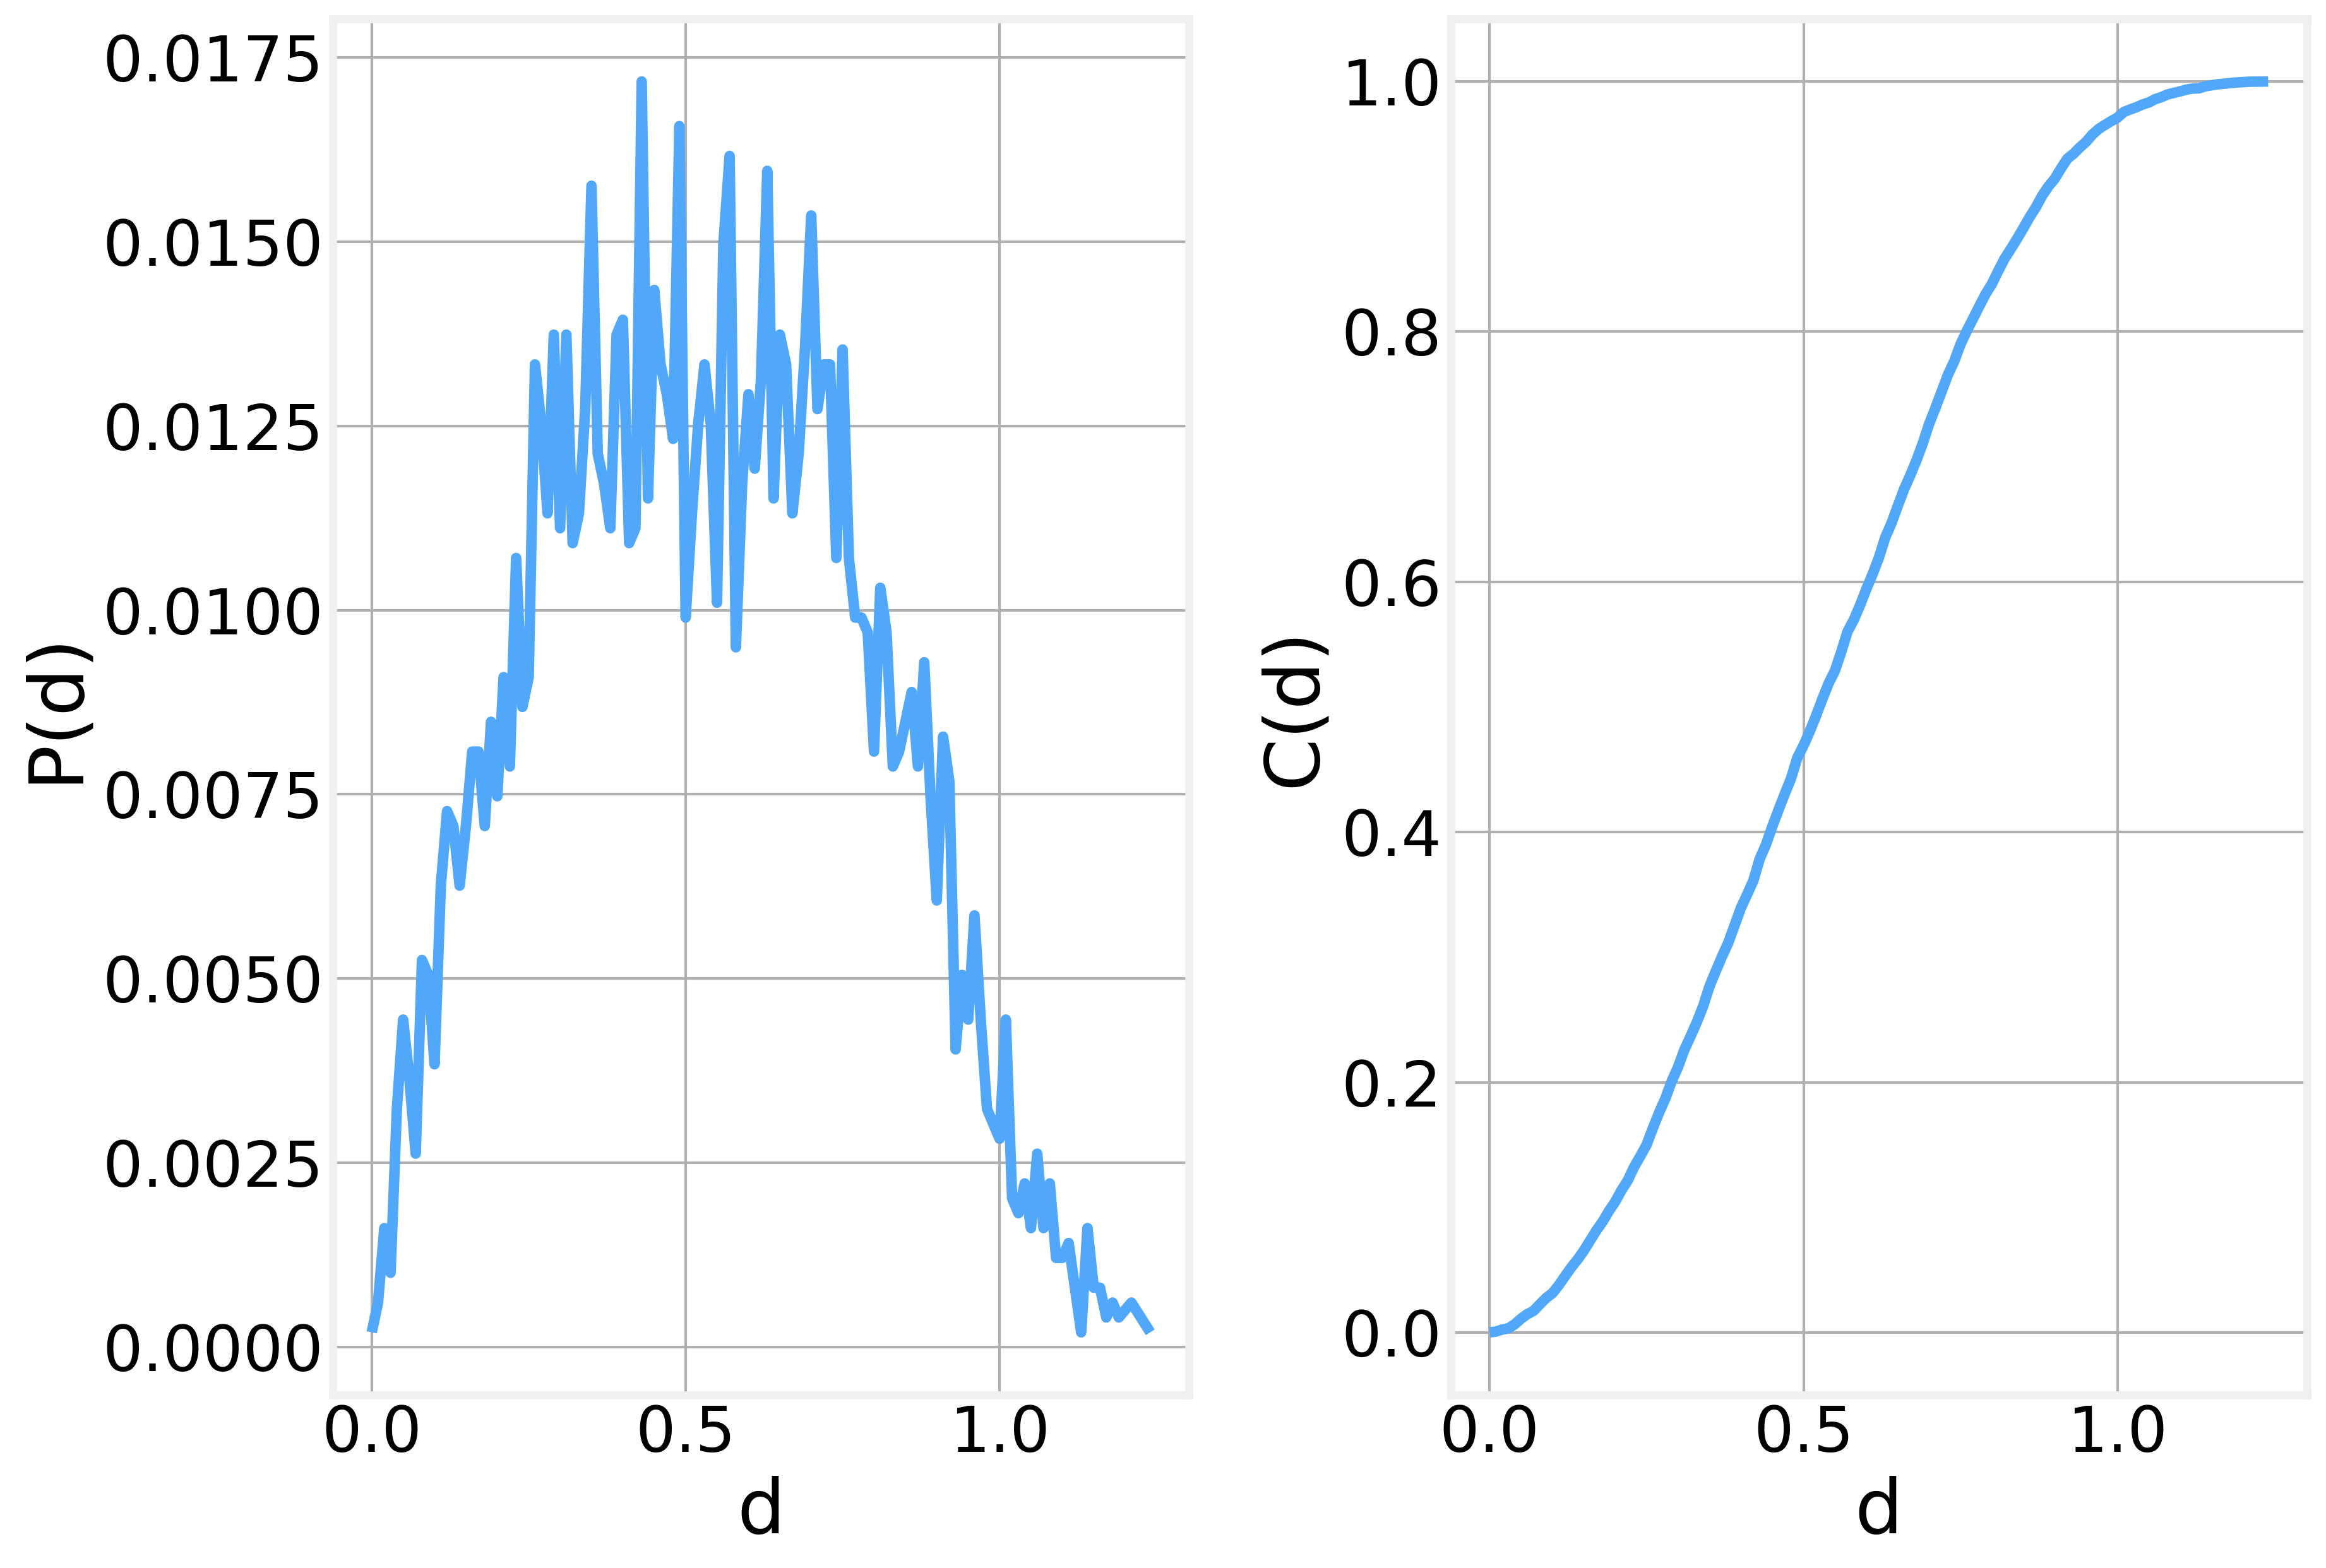

In [11]:
fig, (ax, ax2) = plt.subplots(1, 2)
hist.plot(x='d', y='P(d)', ax=ax, legend=False)
ax.set_ylabel('P(d)')
cumul = hist.copy()
cumul['P(d)'] = hist['P(d)'].cumsum()
cumul.plot(x='d', y='P(d)', ax=ax2, legend=False)
ax2.set_ylabel('C(d)')

We can also easily compute the mean distance between any two nodes

In [12]:
mean_dist = (hist['d']*hist['P(d)']).sum()
print(mean_dist)

0.5346545454545456


Pretty close to the [exact value](https://people.kth.se/~johanph/habc.pdf) of 0.52140543. If you rerun the code with a larger number of nodes you'll get an even better approximation

Naturally, depending on where we set our threshold we will obtain a different graph. And as the threshold increases, the number of connected components will decrease until all the nodes are connected. For even larger values we'll start having an increasing denser graph until, eventually, every node is connected to every other node

In [13]:
@interact
def plot_selection(Threshold = widgets.FloatSlider(
    min=0.01, 
    max=0.25, 
    step=0.01, 
    value=.01, 
    readout=True)):
    
    selection = matrix.copy()
    selection[selection>Threshold] = 0
    
    edges = sorted([[i, j, matrix[i, j]] 
                    for i, j in np.asarray(np.nonzero(selection)).T], key=lambda x:x[2])
    edges_array = np.asarray(edges)
    
    G = nx.Graph()
    G.add_nodes_from(np.arange(N))
    G.add_edges_from(edges_array[:, :2].astype('int').tolist())
    
    print("Number of conneced components:", len(list(nx.connected_components(G))))

    selection = matrix.copy()
    selection[selection>Threshold] = np.nan
    
    fig, (ax, ax2) = plt.subplots(1, 2)
    ax.imshow(selection, cmap=plt.cm.Reds_r, vmin=0, vmax=1.2)
    
    nx.draw_networkx_edges(G, pos=coords,
                           edge_color=plt.cm.Reds_r(edges_array.T[2].T), 
                           alpha=1, ax=ax2)
    ax2.scatter(coords[:, 0], coords[:, 1], color=colors[1], s=100)
    ax2.axis('off')
    
    ax2.set_aspect(1.)

interactive(children=(FloatSlider(value=0.01, description='Threshold', max=0.25, min=0.01, step=0.01), Output(…

# K-Nearest Neighbors

We can build a quick KNN implementation by generating the distance matrix and then selecting the k nearest nodes in each row. We achieve this easily using the somewhat obscure [np.argpartition](https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html) numpy function

In [14]:
def knn(coords, k=2):
    matrix = distance_matrix(coords, coords)
    
    NN = np.argpartition(matrix, k+1, axis=1)[:, :k+1]
    
    return NN

And we convert the thresholded matrix into a list of edges

In [15]:
def get_edges(coords, k=3):
    NN = knn(coords, k)
    
    edges = []
    
    for i in range(len(NN)):
        edges.extend([(i, NN[i, j]) for j in range(k+1) if NN[i, j] != i])

    return edges

In [16]:
edges = get_edges(coords, 5)
edges = np.asarray(edges)

A quick look at the Adjacency Matrix reveals something interesting.

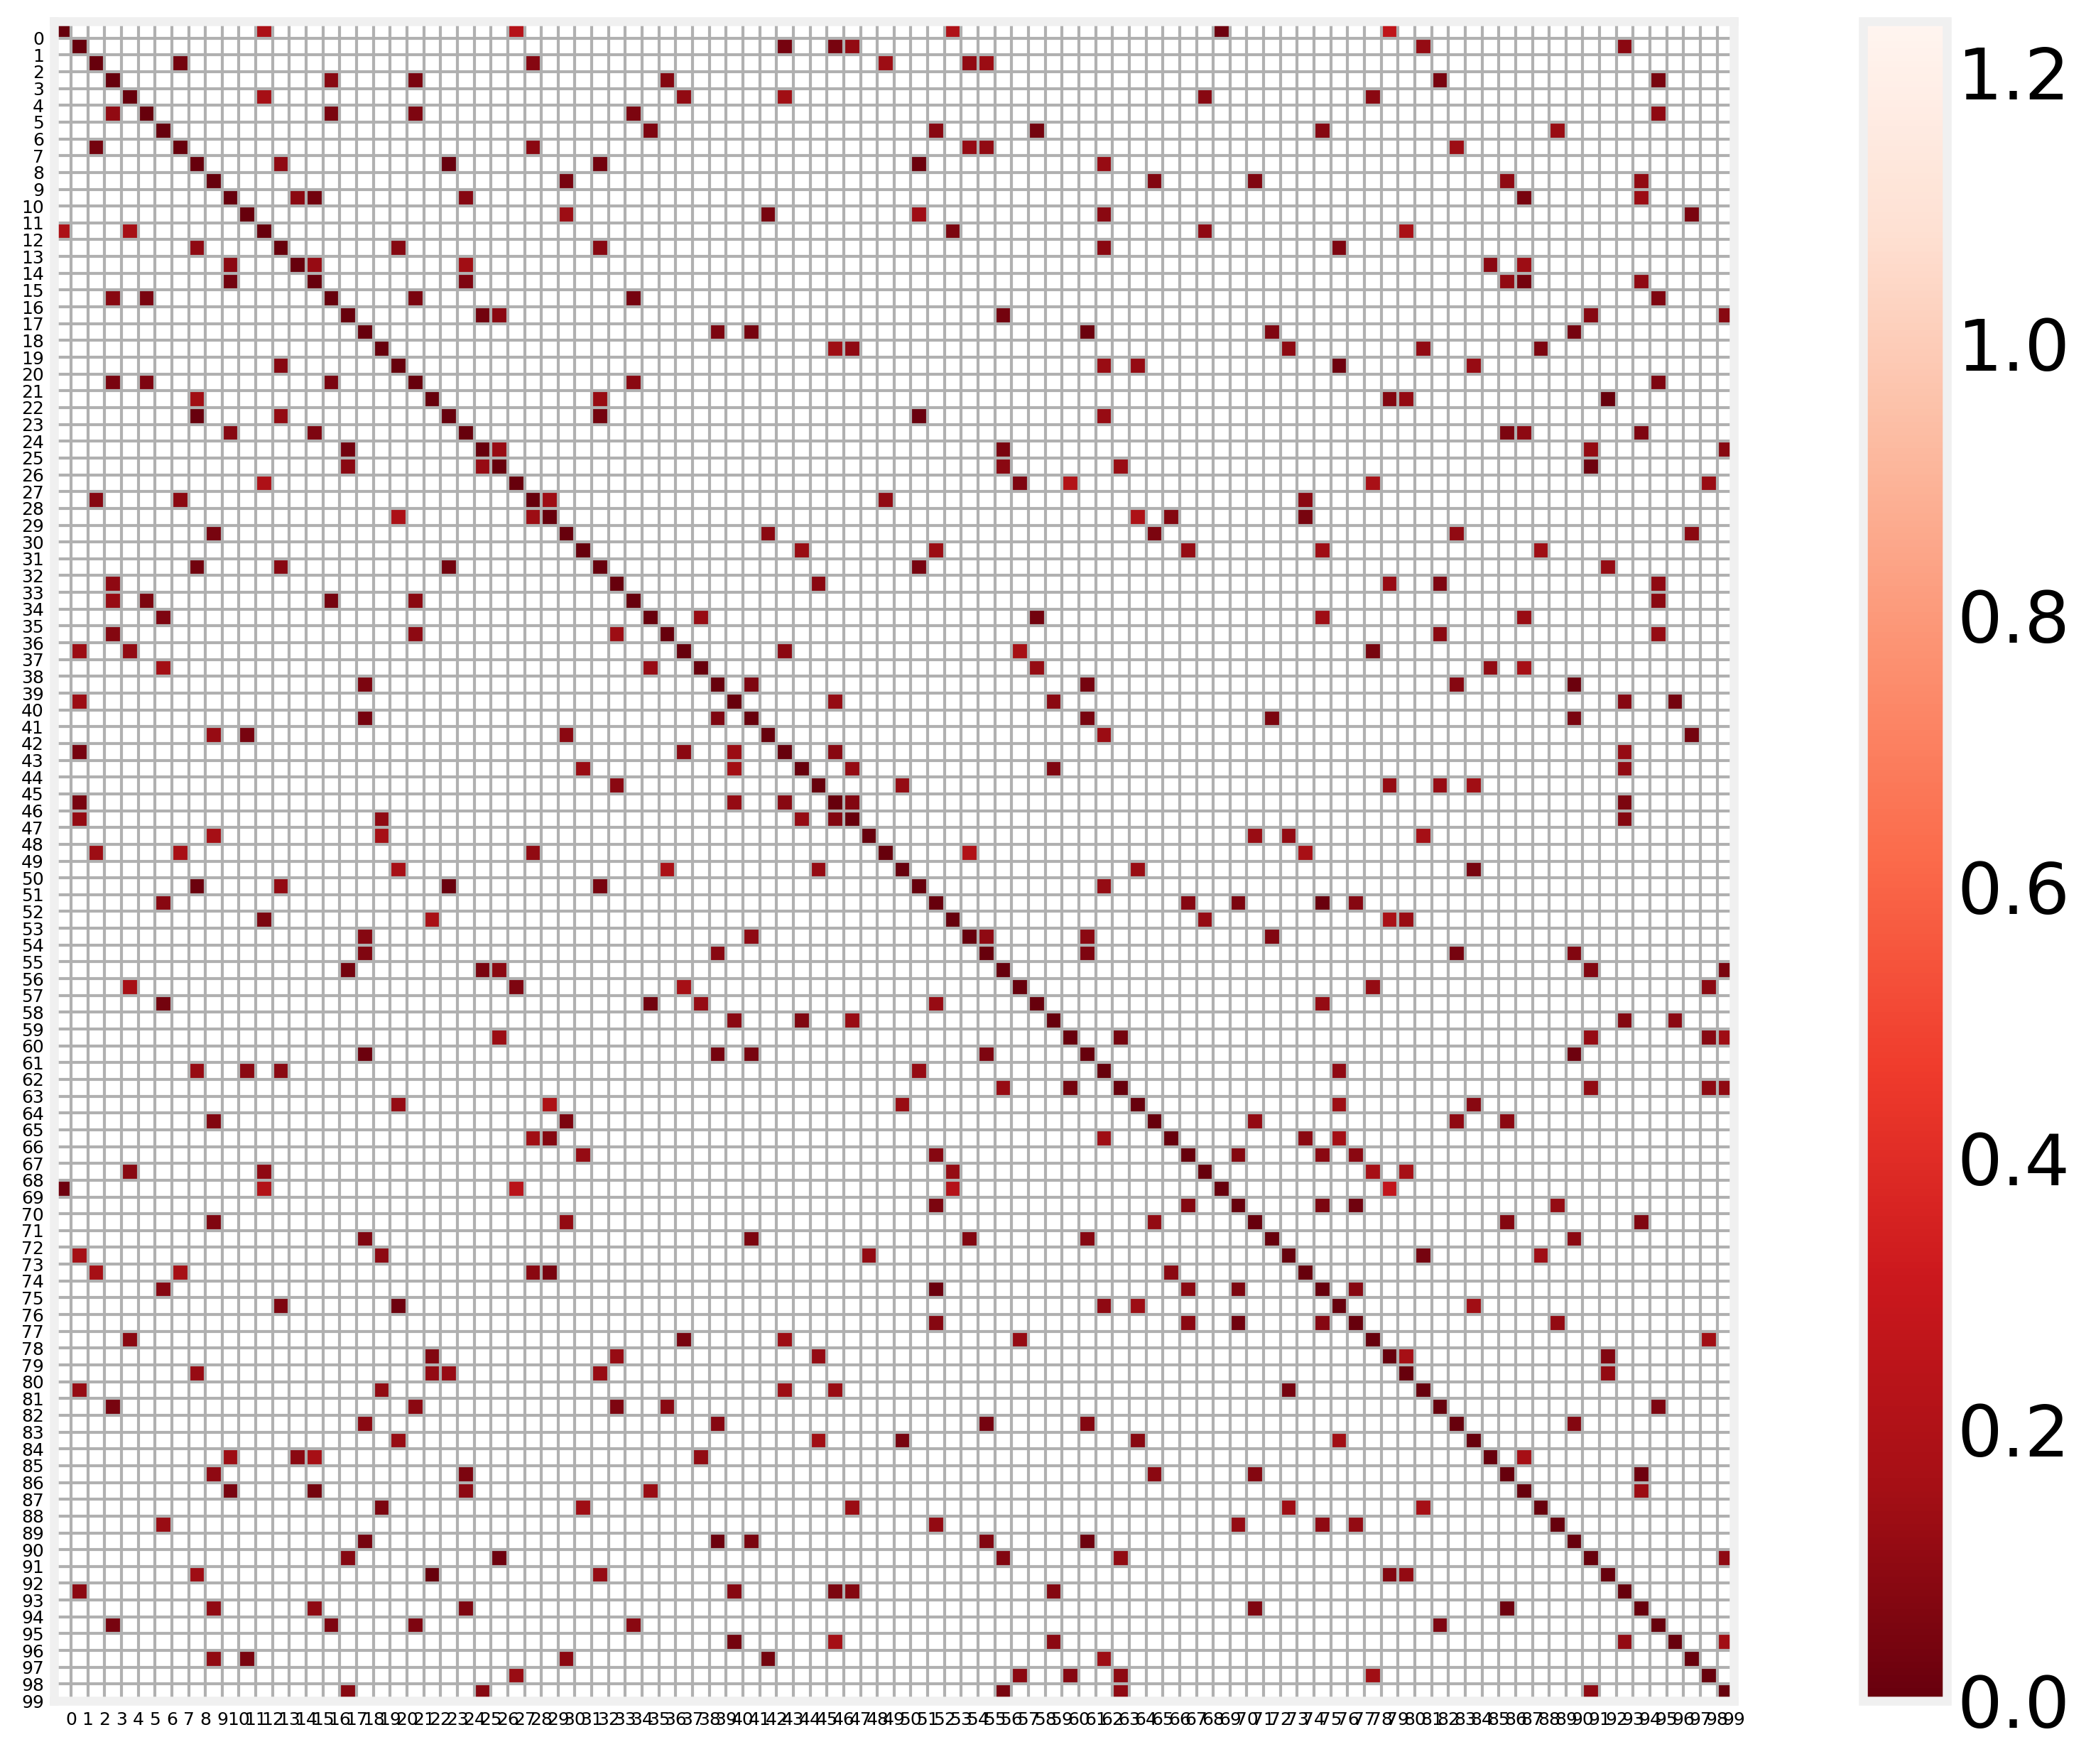

In [17]:
M = np.zeros(matrix.shape, dtype='float')*np.nan
M[edges.T[0], edges.T[1]] = matrix[edges.T[0], edges.T[1]]
M[edges.T[0], edges.T[0]] = 0

plt.imshow(M, cmap=plt.cm.Reds_r, vmin=0, vmax=np.max(matrix))
plt.yticks(np.arange(0.5, N, 1), np.arange(N), fontsize=6)
plt.xticks(np.arange(0.5, N, 1), np.arange(N), fontsize=6)
plt.colorbar();

The KNN graph is ___not symmetrical___! Indeed there are over 240 differences between the Matrix and its transpose

In [18]:
M[np.isnan(M)] = 0
np.sum(np.sign(M)!=np.sign(M.T))

240

Now we build a directed graph using the edges we generated above.

In [19]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(N))
G.add_edges_from(edges)

When we look at the degree distributions, the situation becomes clearer. As expected, all nodes have the an out degree of $5$

In [20]:
Counter([value for key, value in G.out_degree()])

Counter({5: 100})

But he in-degree can vary significantly

Text(0, 0.5, '$P(k_{in})$')

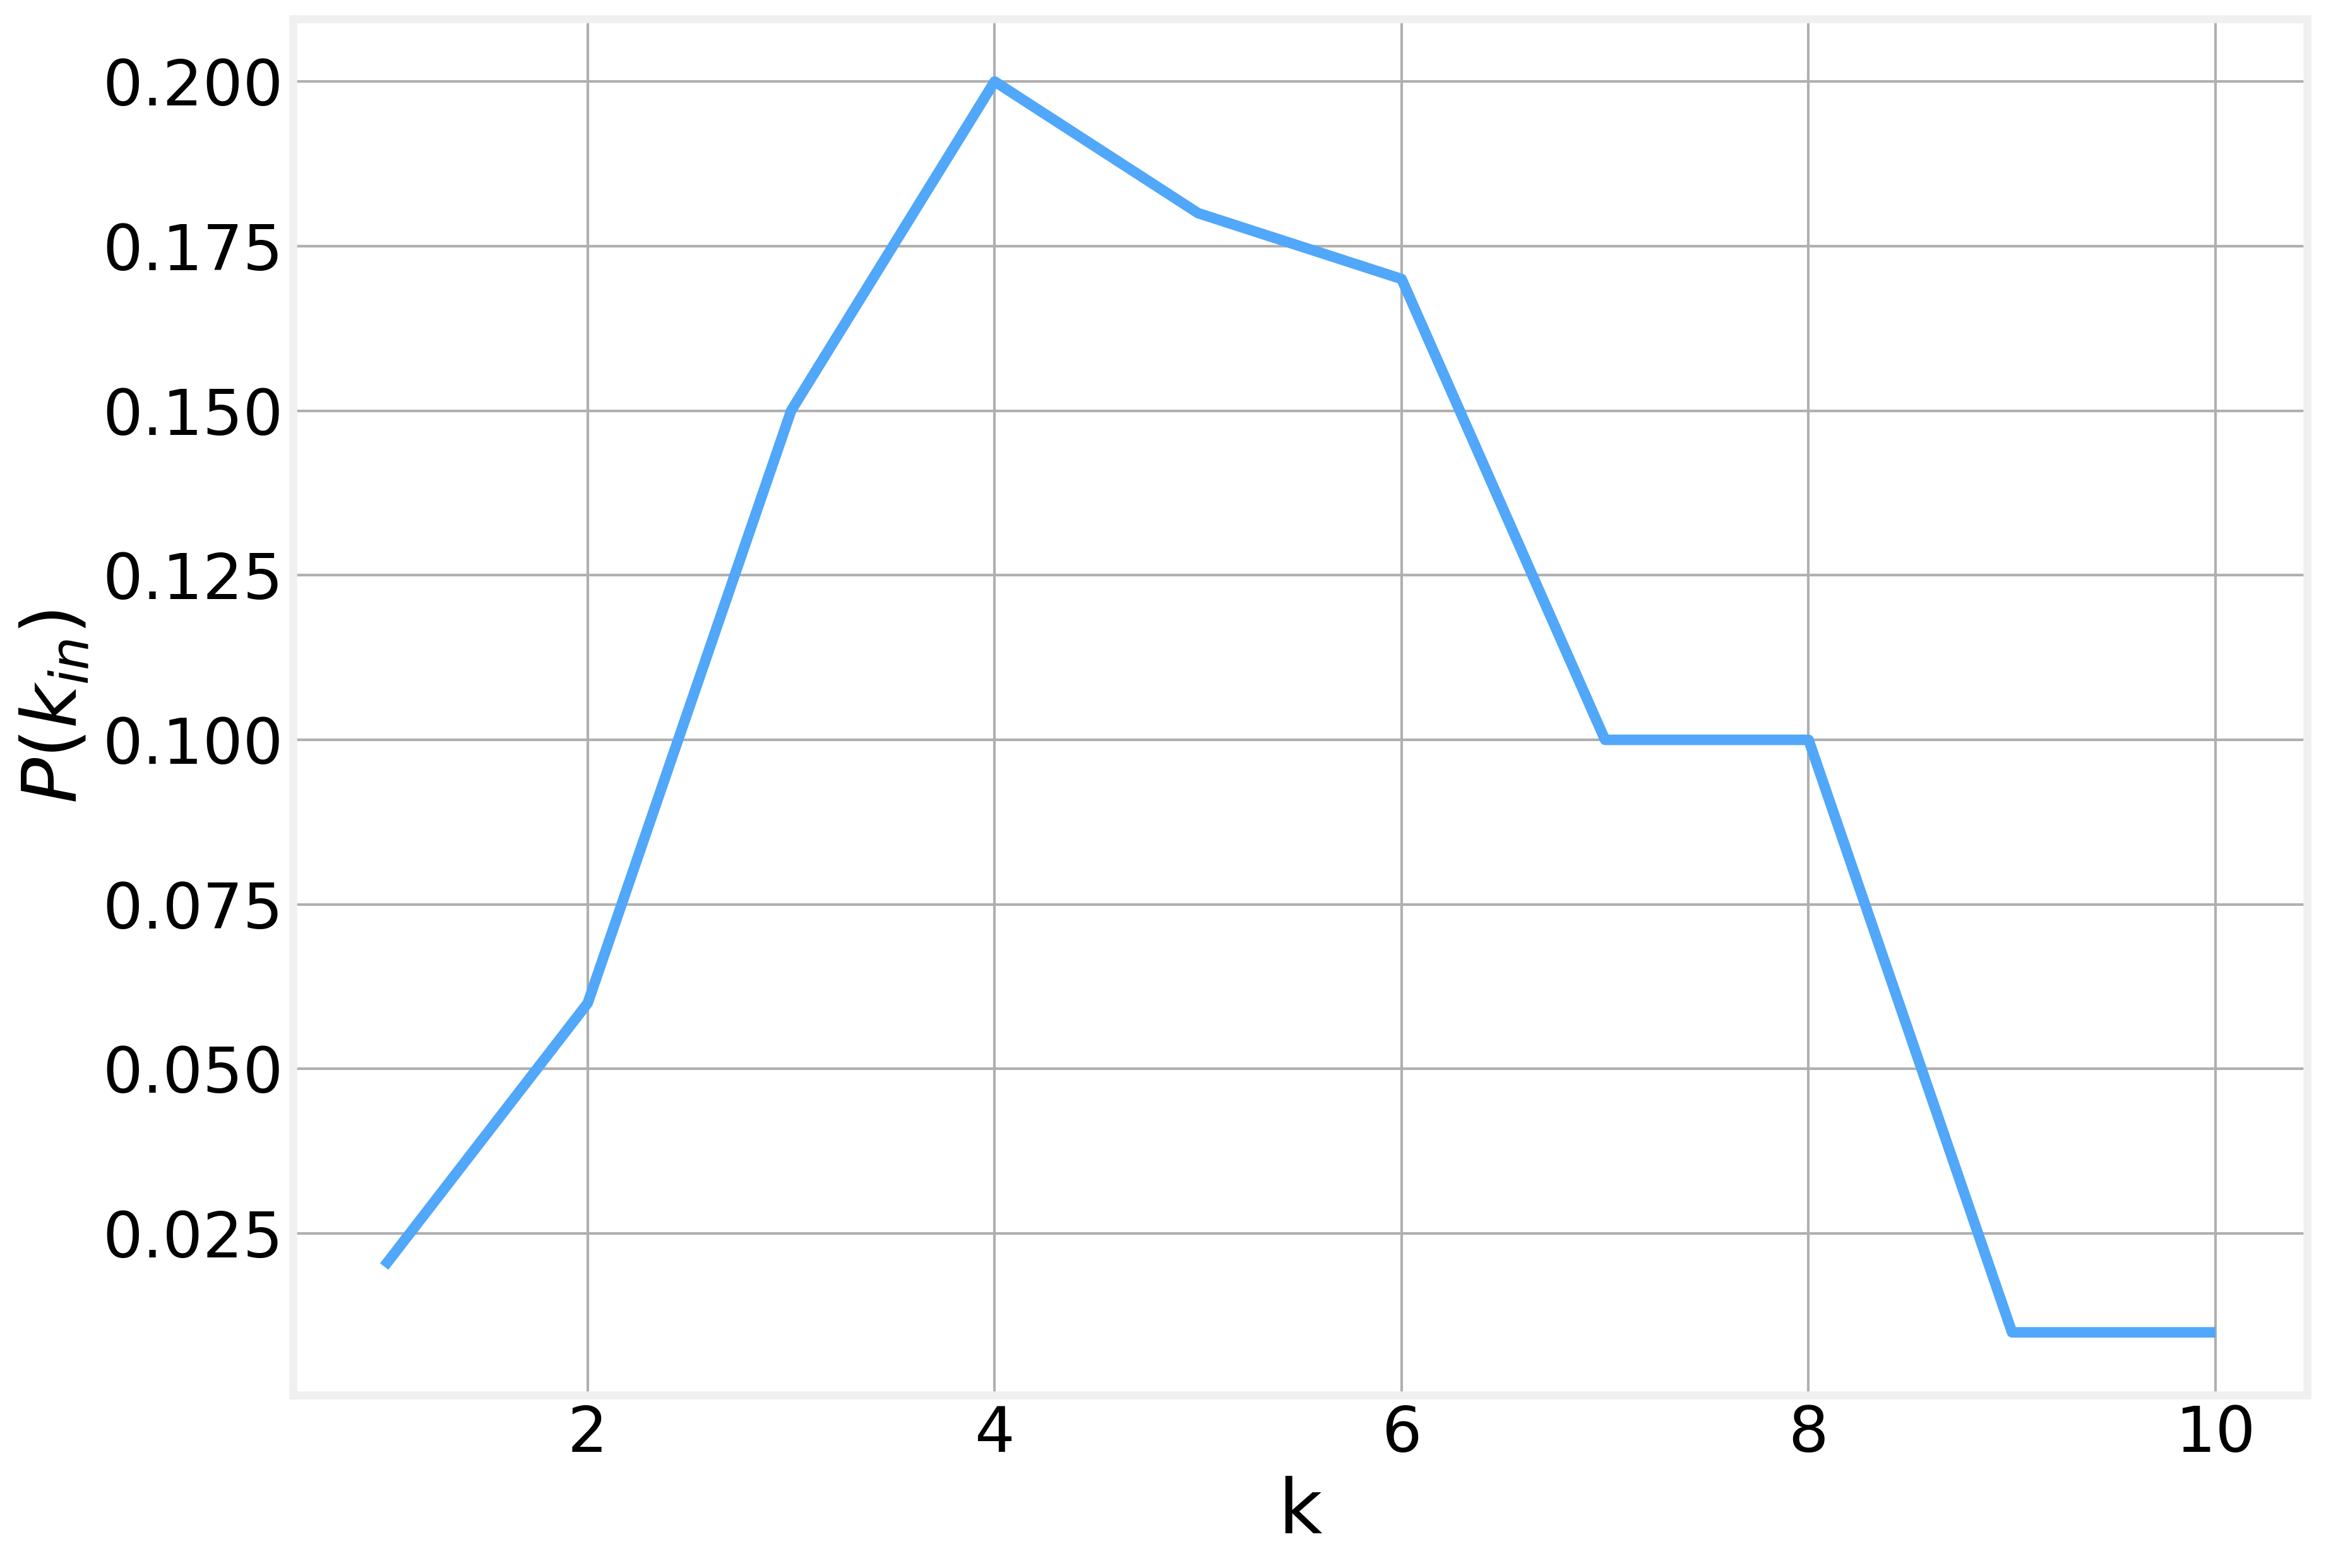

In [21]:
Pk = np.asarray(sorted(Counter([value for key, value in G.in_degree()]).items(), key=lambda x:x[0]))

plt.plot(Pk.T[0], Pk.T[1]/100)
plt.xlabel('k')
plt.ylabel('$P(k_{in})$')

The reason for this is that although the euclidan distance is symmetric, we are breaking the symmerty by choosing the nearest k-neighbours for each node.

In [22]:
node_sizes = np.asarray([value for key, value in G.in_degree()], dtype='float')
node_sizes -= (node_sizes.min()-1)
node_sizes = node_sizes / node_sizes.max()

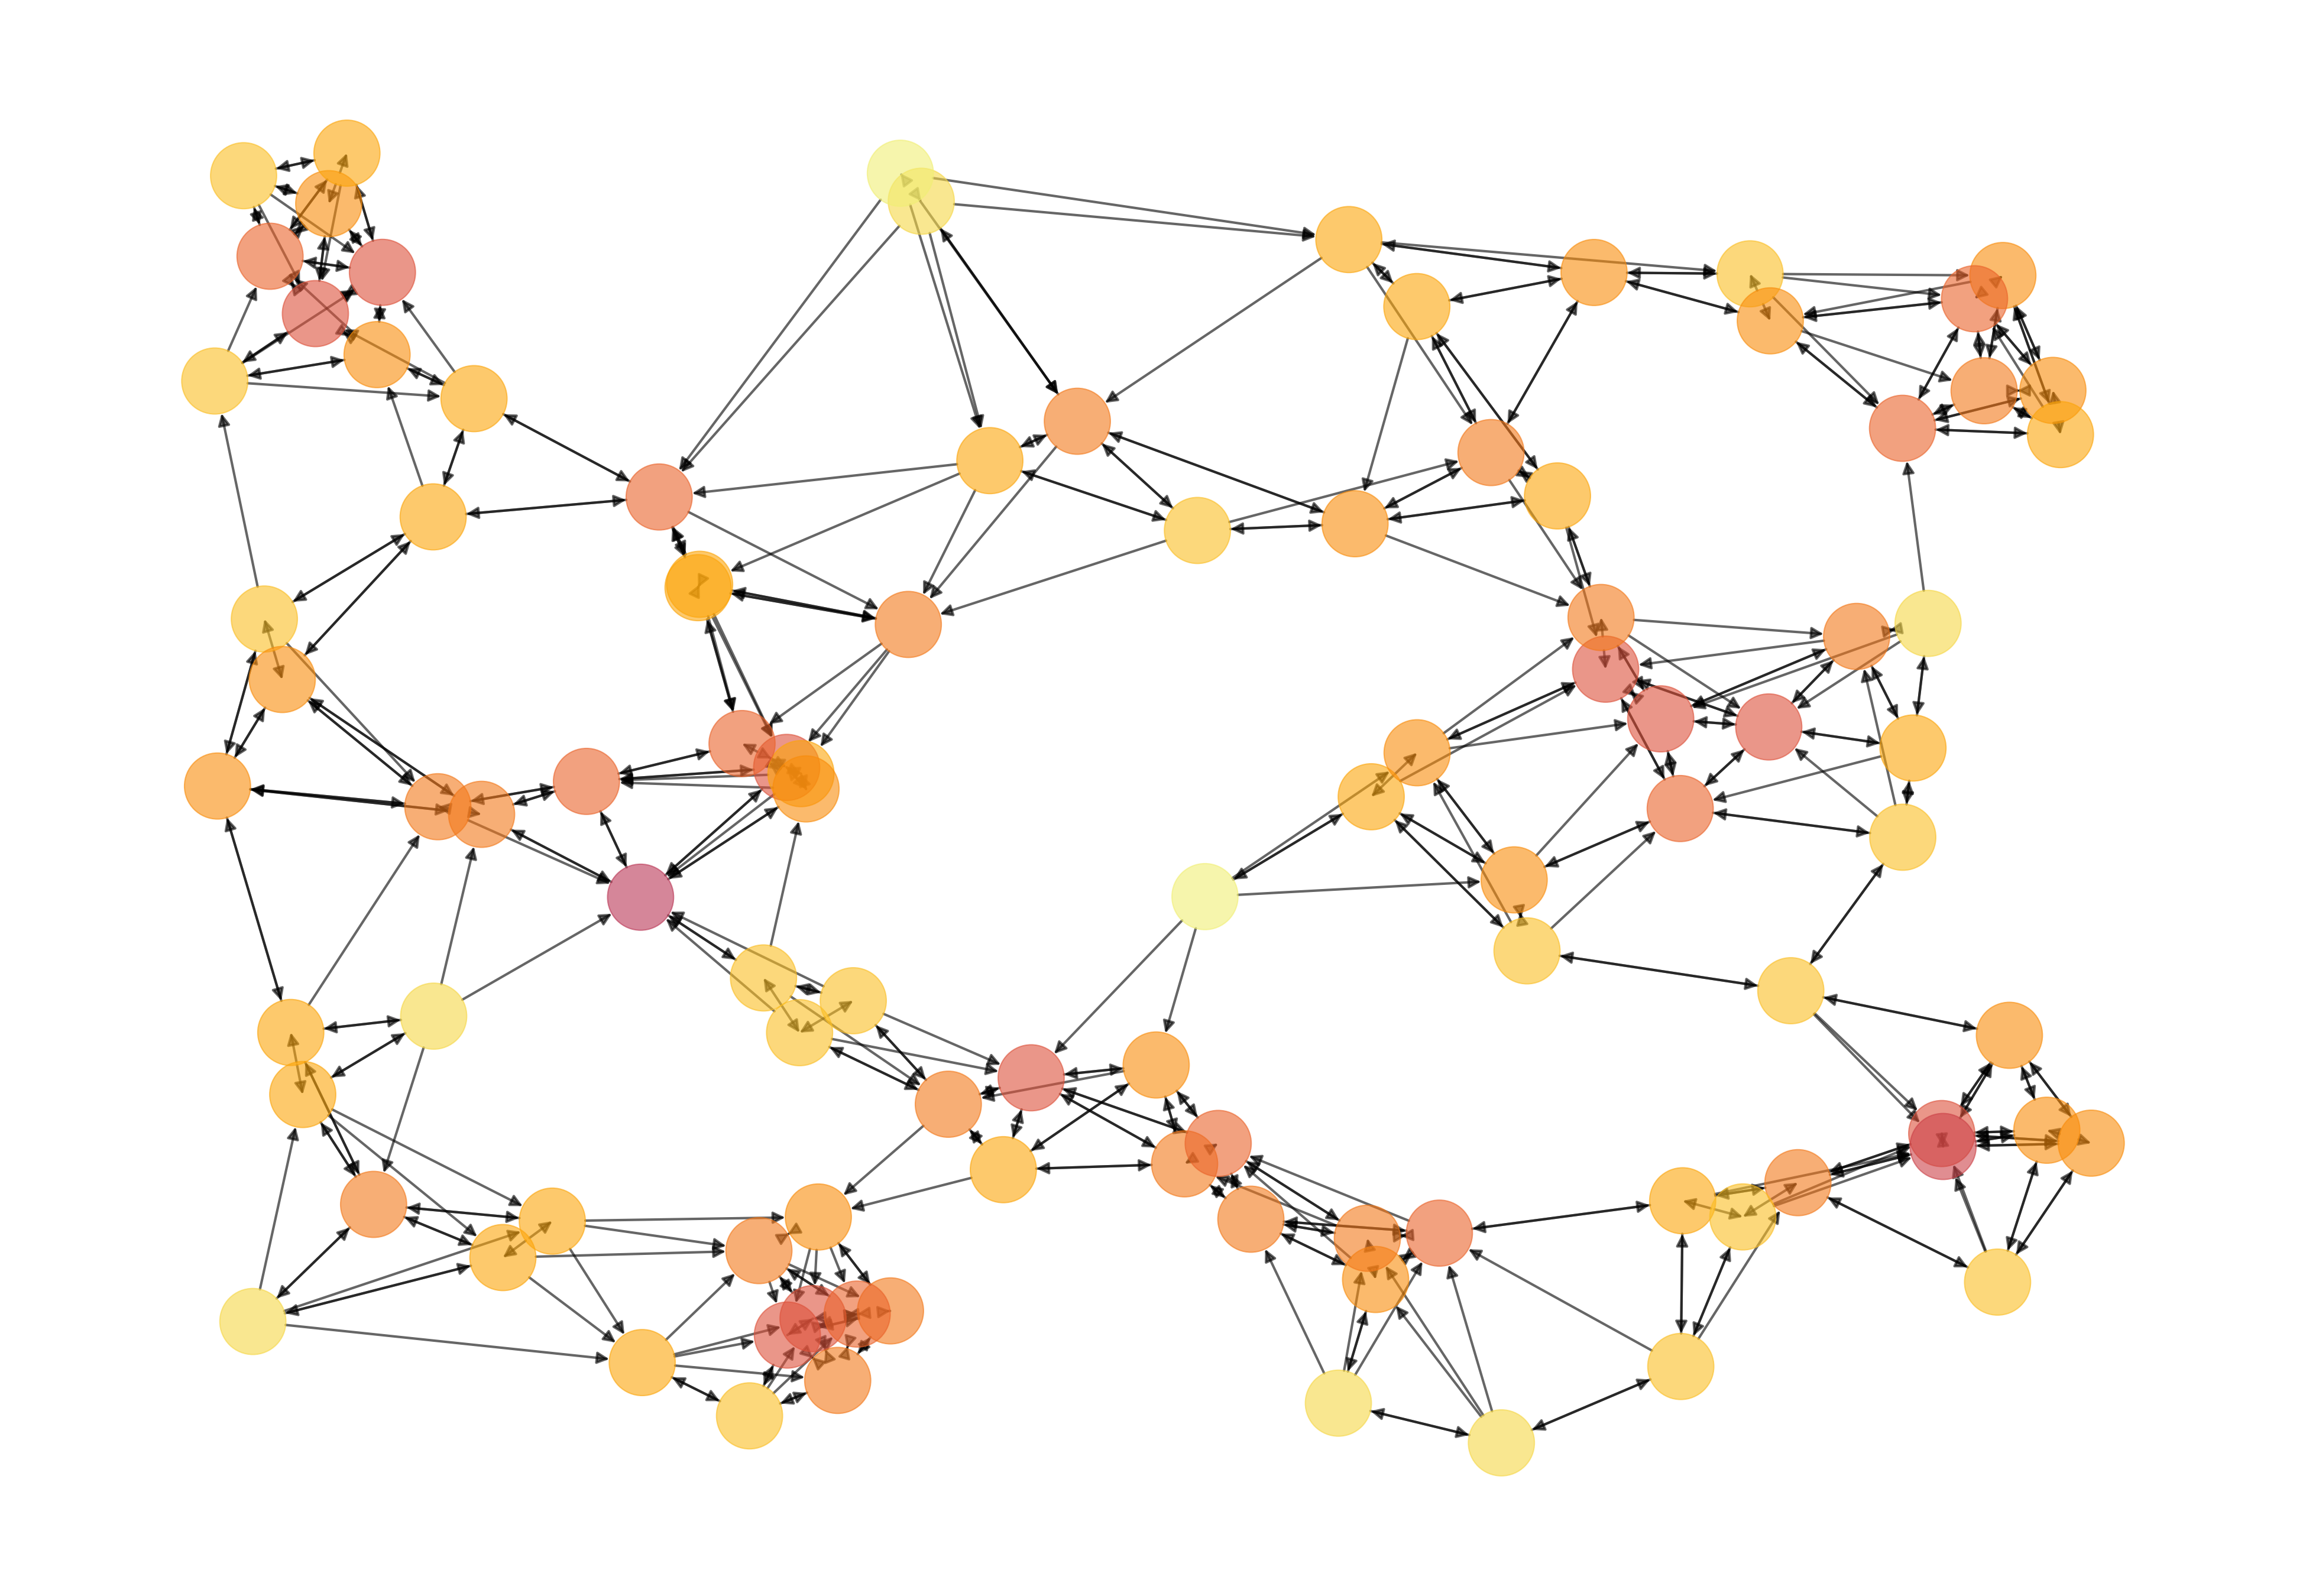

In [23]:
nx.draw(G, pos=coords, node_color=plt.cm.inferno_r(node_sizes/2), 
        node_size=900*(node_sizes.T[1]), alpha=0.6)

# DBSCAN

In [24]:
X, y = datasets.make_moons(n_samples=300, noise=0.08, shuffle=False)

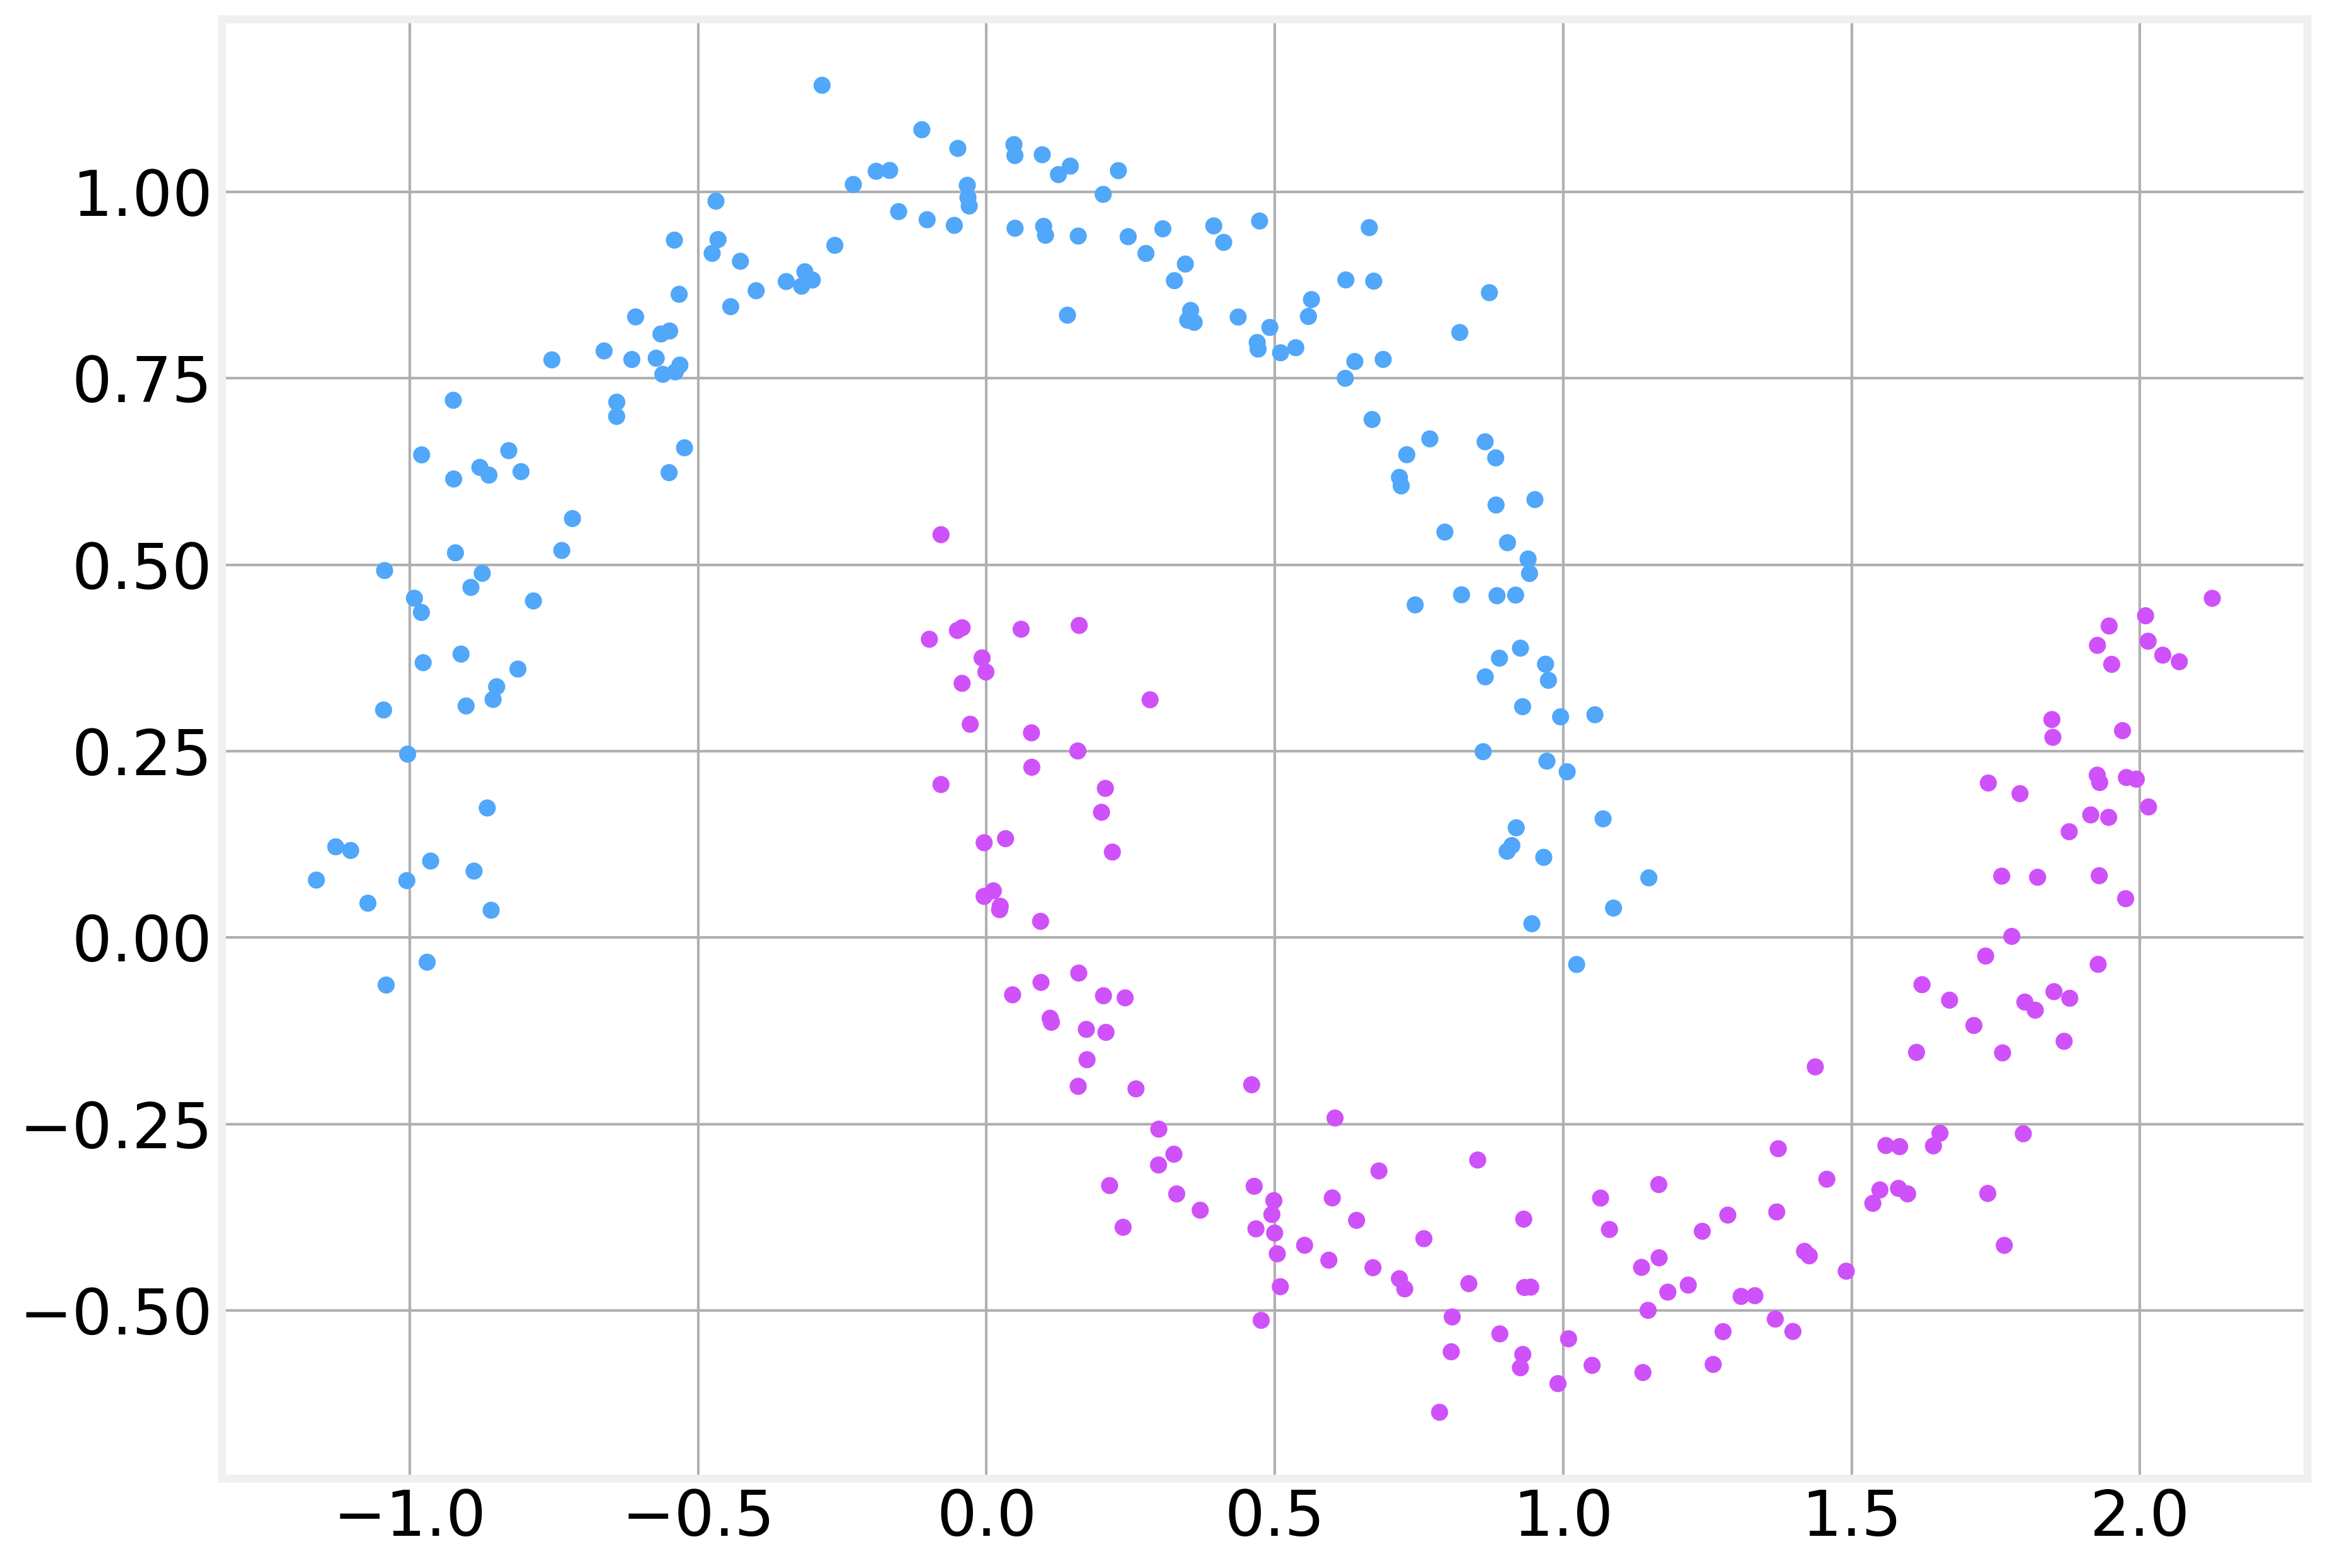

In [25]:
plt.scatter(X.T[0], X.T[1], color=np.array(colors)[y])

In [26]:
def net_DBSCAN(X, eps=0.17, min_samples=5):
    # Building the neighborhood matrix and truncate it 
    # at the maximum distance
    matrix = distance_matrix(X, X)
    matrix[matrix >= eps] = 0

    # Build the directed graph using the non-zero elements of the matrix
    G = nx.DiGraph()
    G.add_edges_from(np.asarray(np.nonzero(matrix)).T)

    # Create an undirected version of the network for ease of core computation
    G2 = G.to_undirected()

    # Find all core nodes
    results = {}
    results['core_sample_indices_'] = [node_i 
                                for node_i, k in G2.degree() 
                                     if k >= min_samples-1]

    # Use the connected components to label each node 
    # as belonging to each cluster
    labels = []
    for label, comp in enumerate(nx.connected_components(G2)):
        for node in comp:
            labels.append(label)

    results['labels_'] = np.asarray(labels)
    results['G'] = G

    # Identify the outlier nodes.
    results['non_core'] = set(np.arange(X.shape[0])) - set(results['core_sample_indices_'])

    return results

In [27]:
results = net_DBSCAN(X, eps=0.17, min_samples=5)

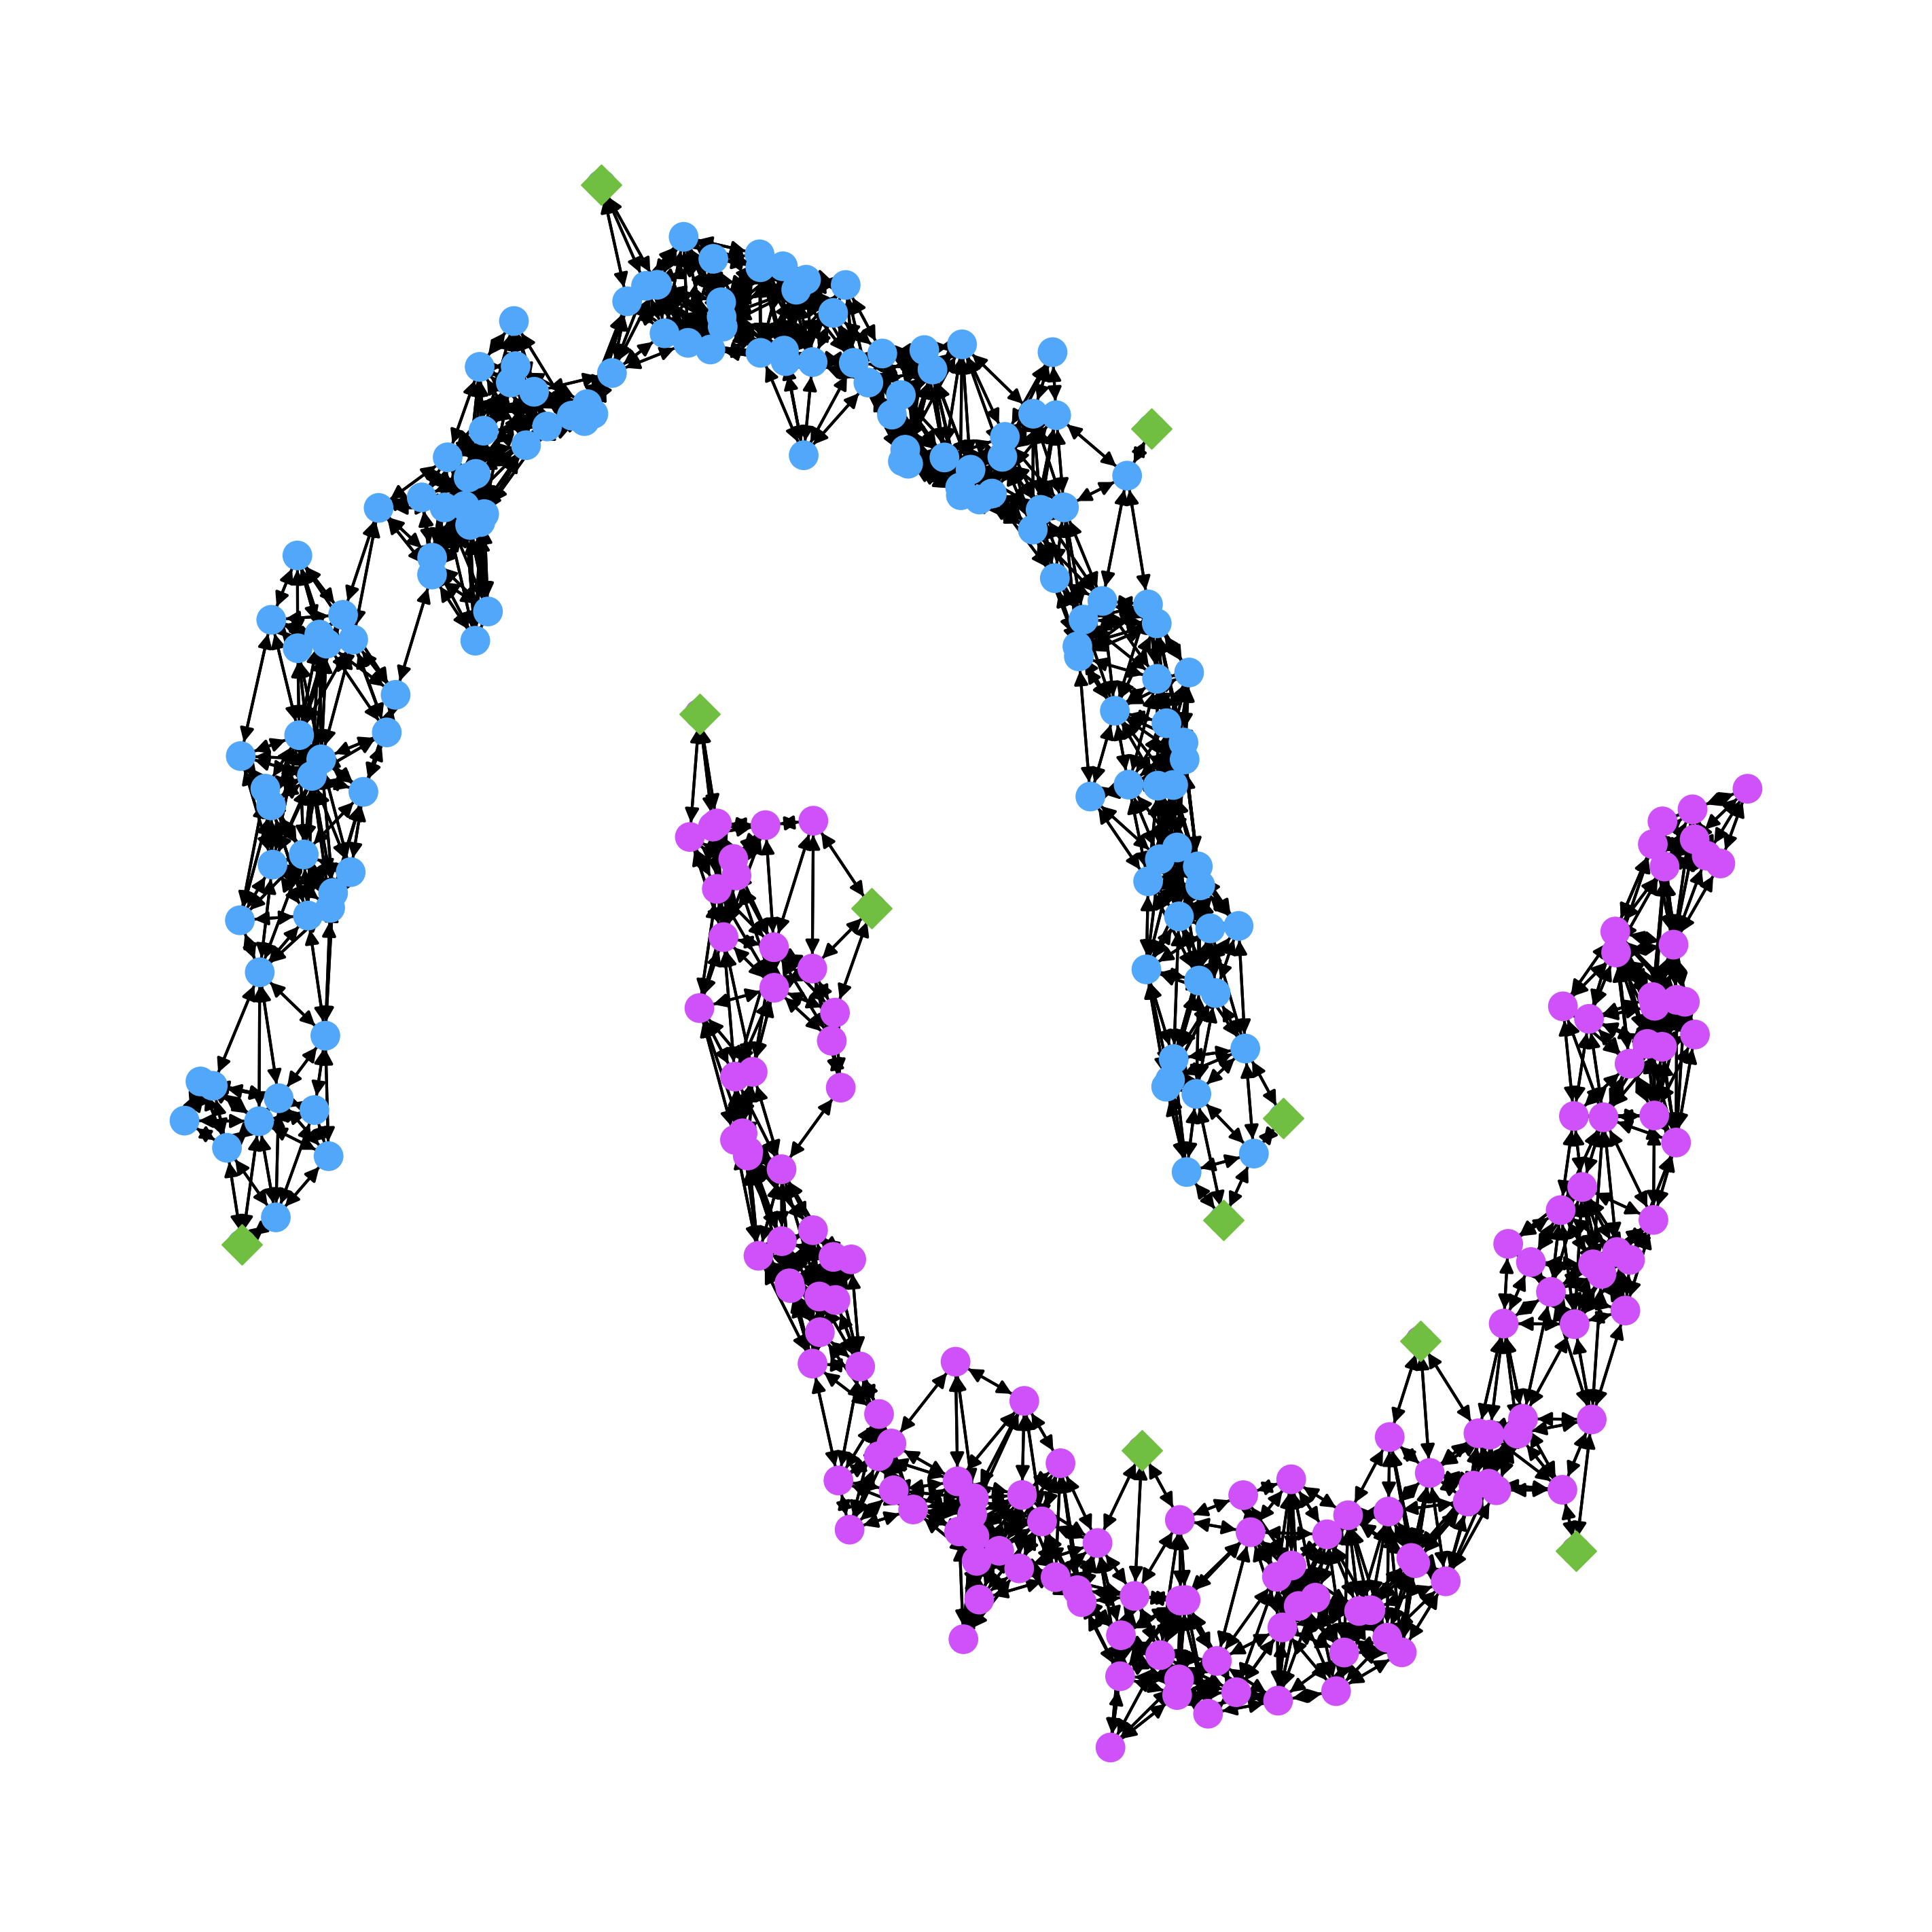

In [28]:
fig, ax = plt.subplots(1, figsize=(10,10))

nx.draw(results['G'], pos=X, 
        ax=ax, 
        node_size=100, 
        node_color=np.asarray(colors)[results['labels_']])

nx.draw_networkx_nodes(results['G'], pos=X,
                       ax=ax,
                       node_size=100, 
                       nodelist=results['non_core'], 
                       node_color=colors[2],
                       node_shape='D')

Now we compare our results with the ones obtained by sklearn on the same dataset

In [29]:
db = DBSCAN(eps=0.17, min_samples=5).fit(X)

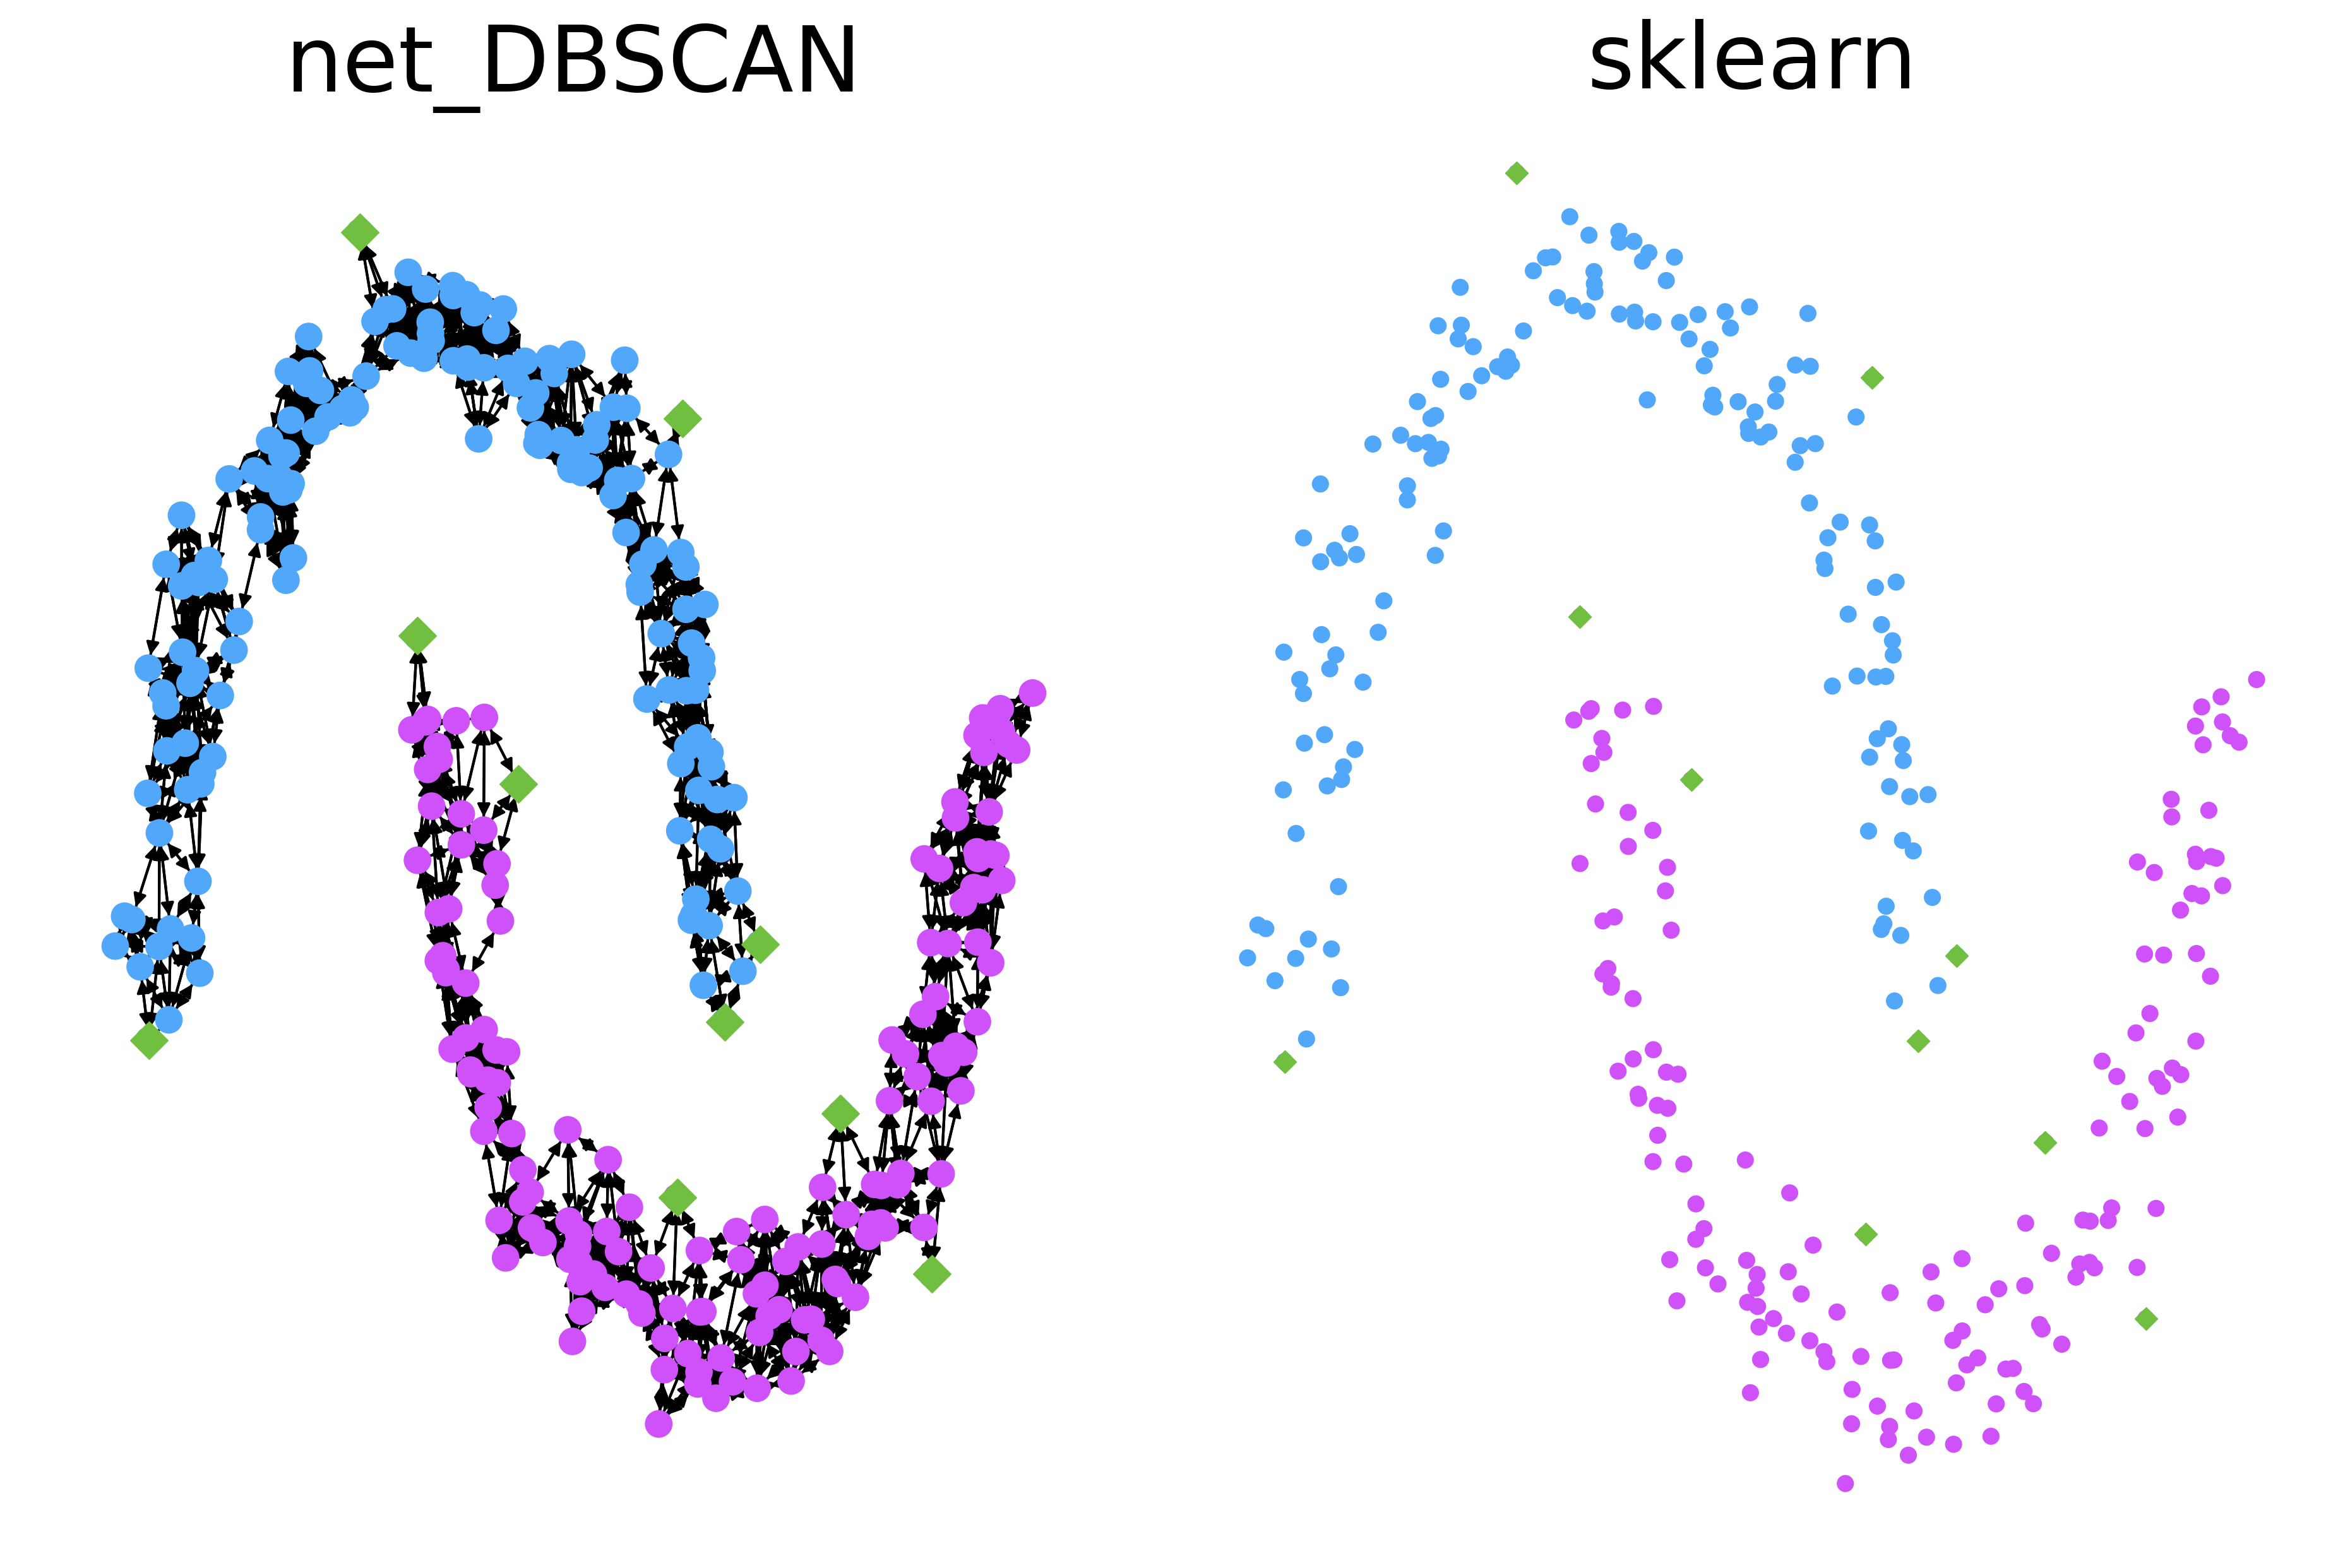

In [30]:
fig, (ax, ax2) = plt.subplots(1, 2)

nx.draw(results['G'], pos=X, 
        ax=ax, 
        node_size=100, 
        node_color=np.asarray(colors)[results['labels_']])

nx.draw_networkx_nodes(results['G'], pos=X,
                       ax=ax,
                       node_size=100, 
                       nodelist=results['non_core'], 
                       node_color=colors[2],
                       node_shape='D')

ax.set_title('net_DBSCAN')

non_core = np.asarray(list(set(np.arange(X.shape[0])) - set(db.core_sample_indices_)))

ax2.scatter(X.T[0], X.T[1], color=np.asarray(colors)[db.labels_])
ax2.scatter(X.T[0][non_core], X.T[1][non_core], marker='D', color=colors[2])

ax2.set_title('sklearn')
ax2.axis('off')
fig.tight_layout();

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>